<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий. Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

# Описание данных

**Технологический процесс**

* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, * Sulphate, Depressant
* Xanthate **— ксантогенат (промотер, или активатор флотации);
* Sulphate — сульфат (на данном производстве сульфид натрия);
* Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

**Параметры этапов**

* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

**Наименование признаков**

Наименование признаков должно быть такое:\
**[этап].[тип_параметра].[название_параметра]**\
Пример: rougher.input.feed_ag

**Возможные значения для блока [этап]:** 

* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики

**Возможные значения для блока [тип_параметра]:**

* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики


**Данные находятся в трёх файлах:**

- **gold_recovery_train.csv** — обучающая выборка;
- **gold_recovery_test.csv** — тестовая выборка;
- **gold_recovery_full.csv** — исходные данные

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.
В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте по нашей инструкции их на корректность.

## Подготовка данных

In [1]:
#Сделаем импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor


In [2]:
#сделаем загрузку данных
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [3]:
data_train.shape, data_test.shape, data_full.shape

((14149, 87), (5290, 53), (19439, 87))

In [4]:
len(data_train) / len(data_full), len(data_test) / len(data_full)

(0.7278666598076032, 0.2721333401923967)

Стандартное разделение выборок: 3:1

In [5]:
display(data_train.head(5))

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [6]:
display(data_test.head(5))

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [7]:
display(data_full.head(5))

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [8]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
date                                                  14149 non-null object
final.output.concentrate_ag                           14148 non-null float64
final.output.concentrate_pb                           14148 non-null float64
final.output.concentrate_sol                          13938 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14049 non-null float64
final.output.tail_sol                                 14144 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14129 non-null float64
primary_cleaner.input.depressant             

In [9]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
date                                          5290 non-null object
primary_cleaner.input.sulfate                 5286 non-null float64
primary_cleaner.input.depressant              5285 non-null float64
primary_cleaner.input.feed_size               5290 non-null float64
primary_cleaner.input.xanthate                5286 non-null float64
primary_cleaner.state.floatbank8_a_air        5290 non-null float64
primary_cleaner.state.floatbank8_a_level      5290 non-null float64
primary_cleaner.state.floatbank8_b_air        5290 non-null float64
primary_cleaner.state.floatbank8_b_level      5290 non-null float64
primary_cleaner.state.floatbank8_c_air        5290 non-null float64
primary_cleaner.state.floatbank8_c_level      5290 non-null float64
primary_cleaner.state.floatbank8_d_air        5290 non-null float64
primary_cleaner.state.floatbank8_d_level      5290 non-null float64
rougher.in

In [10]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
date                                                  19439 non-null object
final.output.concentrate_ag                           19438 non-null float64
final.output.concentrate_pb                           19438 non-null float64
final.output.concentrate_sol                          19228 non-null float64
final.output.concentrate_au                           19439 non-null float64
final.output.recovery                                 19439 non-null float64
final.output.tail_ag                                  19438 non-null float64
final.output.tail_pb                                  19338 non-null float64
final.output.tail_sol                                 19433 non-null float64
final.output.tail_au                                  19439 non-null float64
primary_cleaner.input.sulfate                         19415 non-null float64
primary_cleaner.input.depressant             

Видим, что во всех выборках есть пропущенные значения. Также во всех сетах указан тип данных object, что неприминительно к столбцу date.

**Проверяем, что эффективность обогащения рассчитана правильно**

Эффективность обогащения вычисляем на обучающей выборке для признака rougher.output.recovery по формуле (указана в условиях),где:

C — доля золота в концентрате после флотации (rougher.output.concentrate_au);
F — доля золота в сырье/концентрате до флотации (rougher.input.feed_au);
T — доля золота в отвальных хвостах после флотации (rougher.output.tail_au).

In [11]:
#выберем необходимые для расчета признаки
check = ['rougher.output.concentrate_au',
        'rougher.input.feed_au',
        'rougher.output.tail_au',
        'rougher.output.recovery']

In [12]:
data_check = data_train[check].dropna()

In [13]:
C = data_check['rougher.output.concentrate_au']
F = data_check['rougher.input.feed_au']
T = data_check['rougher.output.tail_au']
recovery = (C * (F-T)) / (F * (C - T)) * 100
print('MAE =', mean_absolute_error(data_check['rougher.output.recovery'], recovery))

MAE = 9.682896147825551e-15


Значение показателя оказалось около нуля, что свидетельствует о корректном расчете эффективности обогащения.

**Сделаем анализ признаков, которые недоступны в тестовой выборке**

В data_test отсутсвует часть признаков data_train. Найдем что это за признаки.

In [14]:
for i in data_full.columns:
    if i not in data_test.columns:
        print(i)

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
final.output.recovery
final.output.tail_ag
final.output.tail_pb
final.output.tail_sol
final.output.tail_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
primary_cleaner.output.tail_au
rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.au_pb_ratio
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_pb
rougher.output.tail_sol
rougher.output.tail_au
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_pb
secondary_cleaner.

В тестовой выборке отсутсвуют все расчётные и выходные (calculation, output) признаки, в том числе целевые — rougher.output.recovery и final.output.recovery. Скорее всего, это объясняется тем, что указанные показатели замеряются и вычисляются позднее.

**Предобработка данных**

Проведем предобработку тренировочной и тестовой выборок, так как обучение модели будет производиться на них.

In [15]:
#заменим формат даты во всех выборках, они у нас  в object 
data_full['date'] = pd.to_datetime(data_full['date'], format='%Y-%m-%d %H:%M:%S')
data_train['date'] = pd.to_datetime(data_train['date'], format='%Y-%m-%d %H:%M:%S')
data_test['date'] = pd.to_datetime(data_test['date'], format='%Y-%m-%d %H:%M:%S')


Пропуски в признаках заполним ближайшими значениями:

In [16]:
data_train = data_train.fillna(method = 'ffill')
data_test = data_test.fillna(method = 'ffill')

In [17]:
data_train.isnull().sum().sum()

0

In [18]:
data_test.isnull().sum().sum()

0

In [19]:

data_test.shape

(5290, 53)

Добавим в тестовую выборку значения целевых признаков из полного датасета:

In [20]:
data_test = pd.merge(data_test, data_full[['date', 'rougher.output.recovery', 'final.output.recovery']], how='left', on='date')

In [21]:
data_test.shape

(5290, 55)

In [22]:
data_test.isna().sum()['rougher.output.recovery']

0

In [23]:

data_test.isna().sum()['final.output.recovery']

0

Произвели замену отсутствующих значений ближайшими; добавили в тестовую выборку значения целевых признаков из полного датасета.

## Анализ данных

**Исследование изменения концентрации элементов (Au - золото, Ag - серебро, Pb - свинец) на каждом этапе**

Золото

In [24]:
au = data_full[['rougher.input.feed_au', 'rougher.output.concentrate_au',
          'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']]
au.columns = ['Сырье', 'Флотация', 'Первичная очистка', 'Конечный результат']

In [25]:
pip install -U seaborn

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.1)
Note: you may need to restart the kernel to use updated packages.


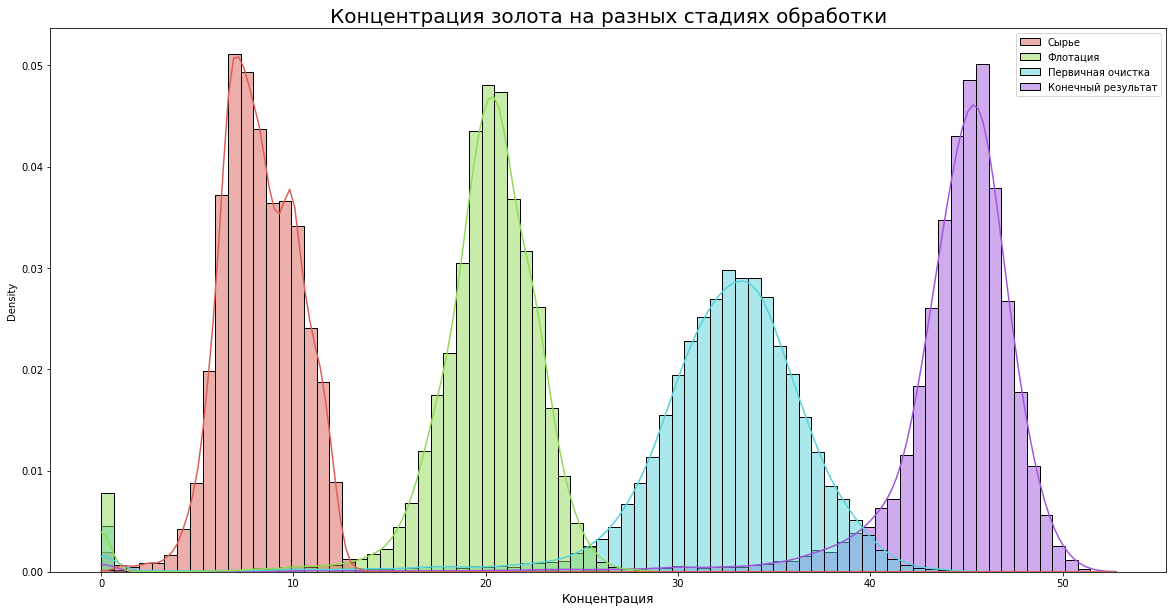

In [26]:
plt.figure(figsize=(20, 10))
sns.histplot(au, bins=80, stat='density', kde=True, label=True, palette='hls')
plt.title('Концентрация золота на разных стадиях обработки', fontsize = 20)
plt.xlabel('Концентрация', fontsize = 12)
plt.show()

Серебро

In [27]:
ag = data_full[['rougher.input.feed_ag', 'rougher.output.concentrate_ag',
          'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']]
ag.columns = ['Сырье', 'Флотация', 'Первичная очистка', 'Конечный результат']

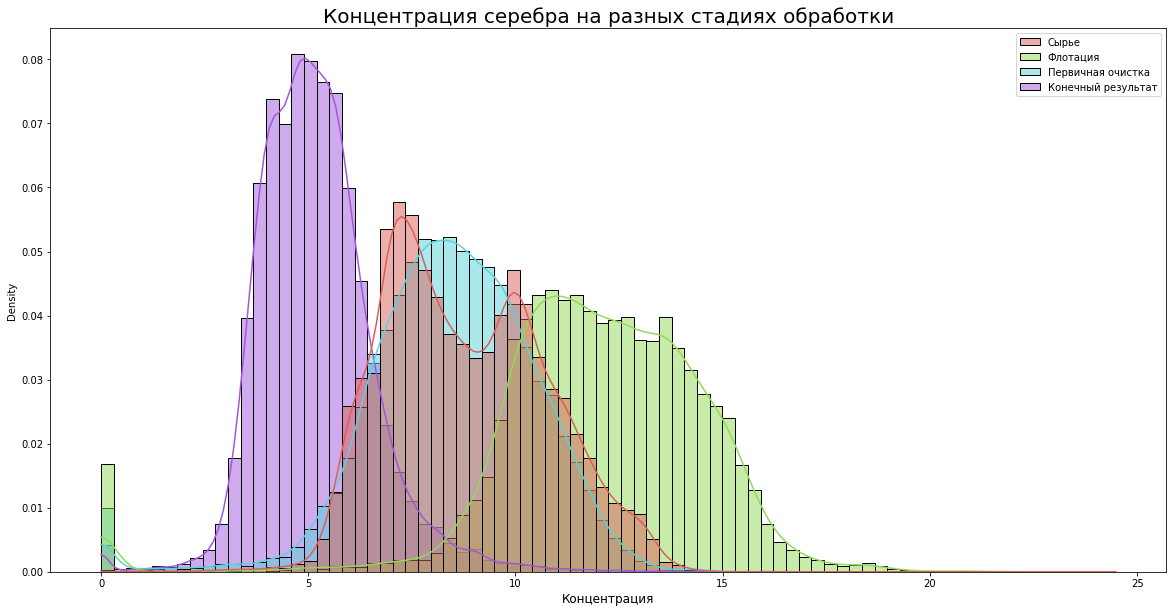

In [28]:
plt.figure(figsize=(20, 10))
sns.histplot(ag, bins=80, stat='density', kde=True, label=True, palette='hls')
plt.title('Концентрация серебра на разных стадиях обработки', fontsize = 20)
plt.xlabel('Концентрация', fontsize = 12)
plt.show()

Свинец

In [29]:
pb = data_full[['rougher.input.feed_pb', 'rougher.output.concentrate_pb',
          'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]
pb.columns = ['Сырье', 'Флотация', 'Первичная очистка', 'Конечный результат']

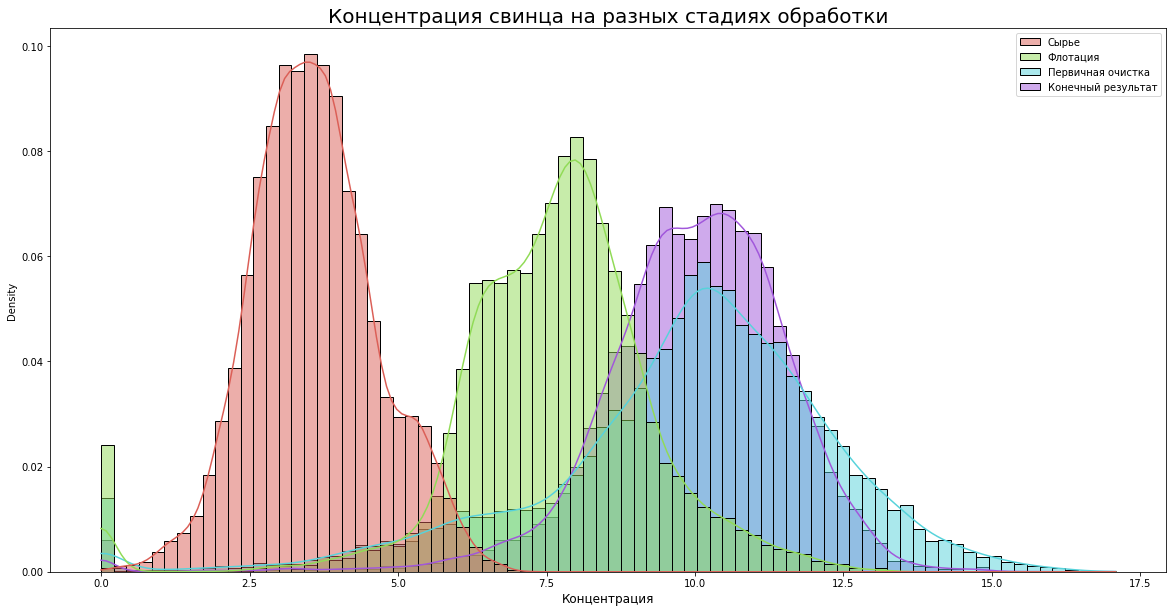

In [30]:
plt.figure(figsize=(20, 10))
sns.histplot(pb, bins=80, stat='density', kde=True, label=True, palette='hls')
plt.title('Концентрация свинца на разных стадиях обработки', fontsize = 20)
plt.xlabel('Концентрация', fontsize = 12)
plt.show()

Можно сделать следующий вывод: 

- Концентрация устойчивости растёт по мере новых этапов очистки (золото);
- Концентрация устойчивости снижается по мере новых этапов очистки (серебро);
- Концентрация свинца повышается в процессе обработки, достигая максимальных значений после первичной очистки, после нее концентрация меняется слабо (Свинец)


Проанализируем распределение размеров гранул на обучающей и тестовой выборках:

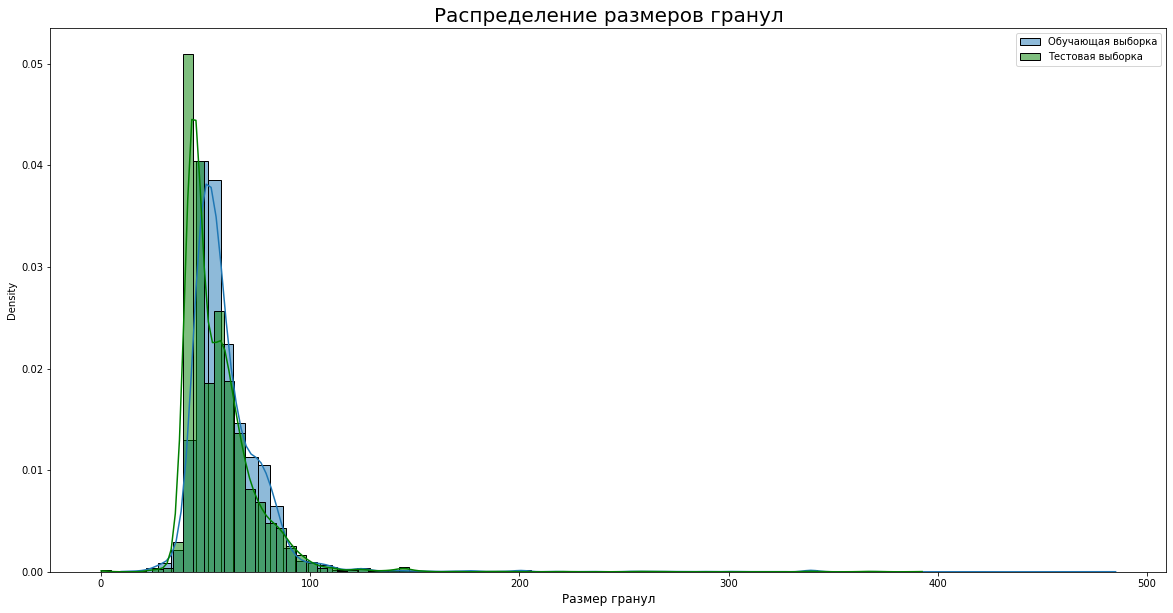

In [31]:
#данные содержаться в столбце 'rougher.input.feed_size'.
plt.figure(figsize=(20, 10))
sns.histplot(data_train['rougher.input.feed_size'], stat='density', label='Обучающая выборка', bins=80, kde=True)
sns.histplot(data_test['rougher.input.feed_size'], stat='density', label='Тестовая выборка', bins=80, kde=True, color='green')
plt.title('Распределение размеров гранул', fontsize = 20)
plt.xlabel('Размер гранул', fontsize = 12)
plt.legend()
plt.show()

Разница некритичная. Тем не менее, в обучающей модели возможна погрешность.

**Проведем исследование суммарных концентраций металлов на разных стадиях**

In [32]:

# Суммарная концентрация металлов в сырье
data_full['rougher.input_feed_total'] = (data_full['rougher.input.feed_ag'] + data_full['rougher.input.feed_pb'] +
                                        data_full['rougher.input.feed_au'])
# Суммарная концентрация металлов в черновом концентрате
data_full['rougher.output.concentrate_total'] = (data_full['rougher.output.concentrate_ag'] + data_full['rougher.output.concentrate_pb'] +
                                             data_full['rougher.output.concentrate_au'])
# Суммарная концентрация металлов в финальном концентрате
data_full['final.output.concentrate_total'] = (data_full['final.output.concentrate_ag'] + data_full['final.output.concentrate_pb'] +
                                          data_full['final.output.concentrate_au'])

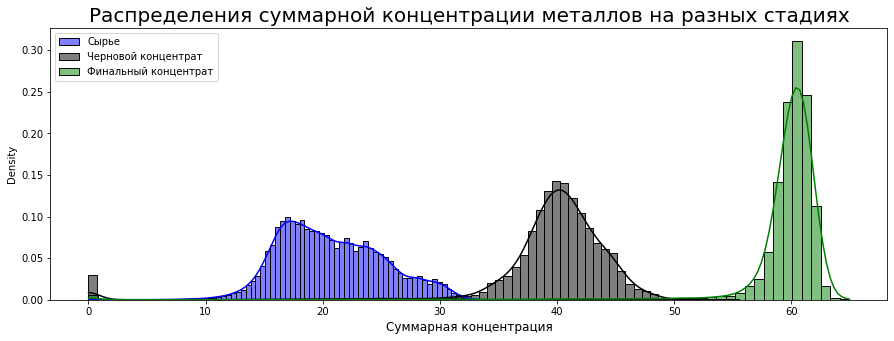

In [33]:

plt.figure(figsize=(15, 5))
sns.histplot(data_full['rougher.input_feed_total'], stat='density', label='Сырье', bins=80, kde=True, color='b')
sns.histplot(data_full['rougher.output.concentrate_total'], stat='density', label='Черновой концентрат', bins=80, kde=True, color='black')
sns.histplot(data_full['final.output.concentrate_total'], stat='density', label='Финальный концентрат', bins=80, kde=True, color='green')
plt.title('Распределения суммарной концентрации металлов на разных стадиях', fontsize = 20)
plt.xlabel('Суммарная концентрация', fontsize = 12)
plt.legend()
plt.show()


Закономерно, что концентрация выше всего на финальной стадии.

In [34]:
data_full['final.output.concentrate_total'].describe()

count    19438.000000
mean        59.224653
std          6.093911
min          0.000000
25%         59.298674
50%         60.307296
75%         61.096690
max         64.968881
Name: final.output.concentrate_total, dtype: float64

В таблице есть данные, где суммарная конценрация металлов в сырье и черновом концентрате имеет нулевое значение. С одной стороны, есть некоторая вероятность присутствия плохой руды, с другой стороны не уверен, что бывает руда совсем уж с нулевым значением хоть какого-то металла. Тут, больше вопрос к специалистам.

In [35]:
#размеры до удаления нулевых значений
print('Обучающая выборка:', data_train.shape)
print('Тестовая выборка:', data_test.shape)

Обучающая выборка: (14149, 87)
Тестовая выборка: (5290, 55)


In [36]:
total_columns = (data_full['rougher.input_feed_total'] == 0) \
& (data_full['rougher.output.concentrate_total'] == 0) \
& (data_full['final.output.concentrate_total'] == 0) \

indexes = data_full[total_columns].index
test_indexes = data_test[data_test.index.isin(indexes)].index
train_indexes = data_train[data_train.index.isin(indexes)].index

data_full.drop(indexes, inplace=True)
data_test.drop(test_indexes, inplace=True)
data_train.drop(train_indexes, inplace=True)

In [37]:
print('Обучающая выборка:', data_train.shape)
print('Тестовая выборка:', data_test.shape)

Обучающая выборка: (14149, 87)
Тестовая выборка: (5290, 55)



Проанализированы и обработаны аномальные т.е. нулевые значения в тестовой и тренировочной сетах.

## Модель

In [38]:
def difference_columns(train_large, test_small):
    common = []
    difference = []
    train_large_col = train_large.columns
    test_small_col = test_small.columns
    for i in train_large_col:
        if i in test_small_col:
            common.append(i)
        else:
            difference.append(i)
    return common,difference

In [39]:
common,difference= difference_columns(data_train, data_test)

In [40]:
for i in difference:
    del data_train[i]

In [41]:
print('Обучающая выборка:', data_train.shape)
print('Тестовая выборка:', data_test.shape)

Обучающая выборка: (14149, 55)
Тестовая выборка: (5290, 55)


In [42]:
data_train = data_train.reset_index(drop=True)

In [43]:
data_test = data_test.reset_index(drop=True)

**Напишем функцию для вычисления итогового sMAPE**

In [44]:
#функция sMAPE -симметричное среднее абсолютное процентное отклонение
def smape(target,prediction):
    N = len(target)
    smape = (1/N)*np.sum(np.abs(target - prediction)/((np.abs(target)+np.abs(prediction))/2))*100
    return smape

In [45]:
#функция итоговой sMAPE
def smape_total(rough,final):
    smape_total=0.25*rough+0.75*final
    return smape_total

Выберем модель предсказания эффективности обогащения чернового концентрата (rougher.output.recovery ) и финального концентрата (final.output.recovery)

In [46]:
#smape_scoring = make_scorer(smape)

<div class="alert alert-success">
<h1>Комментарий студента: <a class="tocSkip"></a></h1>
Из-за параметра greater_is_better=False, мы получаем отрицательные значения smape при кросс-валидации (ниже). Как бы мы просим самую низкую метрику и оно добавляет минус, чтобы уже точно самая низкая была =) Общался с преподавателем по проектам и ребятами в чате. Сошлись во мнение, что нужно игнорировать. Прошлый код закомментировал, вбил новый. 
</div>

In [47]:
smape_scoring = make_scorer(smape, greater_is_better=False)

In [48]:
train_features = data_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
train_target_rougher = data_train['rougher.output.recovery']
train_target_final = data_train['final.output.recovery']



test_features = data_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
test_target_rougher = data_test['rougher.output.recovery']
test_target_final = data_test['final.output.recovery']

In [49]:
train_features.shape

(14149, 53)

In [50]:

test_features.shape

(5290, 53)

In [51]:
# Удалим столбец с датой
train_features = train_features.drop(['date'], axis=1)
test_features = test_features.drop(['date'], axis=1)

**Модель линейной регрессии**

In [52]:
print('Линейная регрессия:')
model_lrrougher = LinearRegression()
final_score_lrrougher = (cross_val_score(model_lrrougher, train_features, train_target_rougher, cv=5, scoring=smape_scoring).mean())
print('sMAPE (rougher):', final_score_lrrougher.round(decimals=2), '%')

model_lrfinal = LinearRegression()
final_score_lrfinal = (cross_val_score(model_lrfinal, train_features, train_target_final, cv=5, scoring=smape_scoring).mean())
print('sMAPE (final):', final_score_lrfinal.round(decimals=2), '%')

print('Итоговое sMAPE:', smape_total(final_score_lrrougher, final_score_lrfinal).round(decimals=2), '%')

Линейная регрессия:
sMAPE (rougher): -12.8 %
sMAPE (final): -12.25 %
Итоговое sMAPE: -12.38 %


**Случайный лес**

In [53]:
params = { 
    'n_estimators': [10, 50, 100],
    'max_depth' : [5, 7, 10]}

Начальный этап

In [54]:
model = RandomForestRegressor()

In [55]:
clf = GridSearchCV(estimator=model, param_grid =params,  cv=3,  n_jobs=-1, scoring=smape_scoring)

In [56]:
clf.fit(train_features , train_target_rougher)
rougher_pred=clf.predict(test_features)
smape_rougherRF = smape(rougher_pred, test_target_rougher)
print('sMAPE (rougher):', smape_rougherRF.round(decimals=2), '%')

sMAPE (rougher): 10.17 %


Финальный этап

In [57]:
model = RandomForestRegressor()
clf = GridSearchCV(estimator=model, param_grid =params,  cv=3,  n_jobs=-1, scoring=smape_scoring)
clf.fit(train_features, train_target_final)
final_pred=clf.predict(test_features)
smape_finalRF = smape(final_pred, test_target_final)
print('sMAPE (final):', smape_finalRF.round(decimals=2), '%')

sMAPE (final): 9.55 %


In [58]:
print('Итоговое sMAPE:', smape_total(smape_rougherRF, smape_finalRF).round(decimals=2), '%')

Итоговое sMAPE: 9.7 %


**Дерево решений**

In [59]:
params = {'min_samples_leaf': list(range(2,21)),
    'min_samples_split': list(range(2,6)),
    'max_depth' : list(range(2,11))}

Начальный этап

In [60]:
model = DecisionTreeRegressor()
clf = GridSearchCV(estimator=model, param_grid =params,  cv=3,  n_jobs=-1, scoring=smape_scoring)
clf.fit(train_features , train_target_rougher)
rougher_predDT=clf.predict(test_features)
smape_rougherDT = smape(rougher_predDT, test_target_rougher)
print('sMAPE (rougher):', smape_rougherDT.round(decimals=2), '%')

sMAPE (rougher): 10.47 %



Финальный этап

In [61]:
model = DecisionTreeRegressor()
clf = GridSearchCV(estimator=model, param_grid =params,  cv=3,  n_jobs=-1, scoring=smape_scoring)
clf.fit(train_features, train_target_final)
final_predDT=clf.predict(test_features)
smape_finalDT = smape(final_predDT, test_target_final)
print('sMAPE (final):', smape_finalDT.round(decimals=2), '%')

sMAPE (final): 9.3 %


In [62]:
print('Итоговое sMAPE:', smape_total(smape_rougherDT, smape_finalDT).round(decimals=2), '%')

Итоговое sMAPE: 9.6 %


Наименьший процент отклонения выдала модель случайного леса. Проверим модели:обучим модели на полных данных и посчитаем sMAPE.

In [63]:
model_final = RandomForestRegressor(random_state=12345, 
                                       n_estimators=20, 
                                       max_depth=3)

model_final.fit(train_features, train_target_rougher)
predictions_r = model_final.predict(test_features)

model_final.fit(train_features, train_target_final)
predictions_f = model_final.predict(test_features)

In [64]:

smape_r = smape(test_target_rougher, predictions_r)
smape_f = smape(test_target_final, predictions_f)

print('Итоговое sMAPE:', smape_total(smape_r, smape_f).round(decimals=2), '%')

Итоговое sMAPE: 9.89 %



Для проверки адекватности модели, сравним ее с результатами работы DummyRegressor

In [65]:
dummy_r = DummyRegressor(strategy='mean')

dummy_r.fit(train_features, train_target_rougher)
predictions_r = dummy_r.predict(test_features)

dummy_r.fit(train_features, train_target_final)
predictions_f = dummy_r.predict(test_features)

smape_r = smape(test_target_rougher, predictions_r)
smape_f = smape(test_target_final, predictions_f)

print('Итоговое sMAPE', smape_total(smape_r, smape_f).round(decimals=2), '%')

Итоговое sMAPE 10.29 %


### Вывод

- Проведено изучение данных трех датасетов: проанализированны признаки, проведена предобработка данных; 

- Исследованы стадии очистки сырья и концентрация металлов в зависимости от стадии, закономерно, концентрация металлов повышается с каждой стадией обработки; 

- Проанализировано распределение размеров гранул на обучающей и тестовой выборках; Написаны функции рассчета требуемой метрики итоговой sMAPE; 

- Построены три модели машинного обучения - линейной регрессии, случайного леса и дерева решений. Проведена кросс-валидация и выбор гиперпараметров моделей;

- Выбрана наилучшая модель с подходящими гиперпараметрами - случайный лес;

- Выбранная модель проверена на тестовой выборке. Значение итоговой sMAPE близко к значениям полученным при кросс-валидации - 9.89 %.

- Была обучена Dummy модель для проверки на адекватность. Предсказания дамми модели оказались хуже предсказаний модели случайного леса - 10.29 %.